In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from matplotlib.lines import Line2D
import pandas as pd
from kaldo.phonons import Phonons
from kaldo.forceconstants import ForceConstants
from kaldo.observables.secondorder import SecondOrder
from kaldo.interfaces.shengbte_io import read_second_order_qe_matrix
from scipy import constants as con
# Unit conversions
# THz to cm-1
thz_to_invcm = con.value('hertz-inverse meter relationship')*1e12/100

def phonon_getter(potential, fmt='hiphive'):
    forceconstants=ForceConstants.from_folder(
                supercell=(5,5,1),
                folder=potential,
                format=fmt,
                only_second=True)
    phonons=Phonons(forceconstants=forceconstants,
                    is_classic=True,
                    temperature=300,
                    folder=potential+'/ald/',
                    kpts=(5,5,1),
                    third_bandwidth=0.5/4.135)
    return phonons

generate_path=0

In [6]:
if not generate_path:
    G = (0,0,0)
    M = (1/2, 0, 0)
    K = (1/3, 1/3, 0)
    A = (0, 0, 1/2)
    L = (1/2, 0, 1/2)
    detect = False
    steps = [G,M,K,G]
    labels = [r'$\Gamma$', r'$M$', r'$K$', r'$\Gamma$']
    cell = read('../inse/newmdin/MD_input/monolayer/optunit.xyz').cell.array
    npointstotal=100*len(steps)
    nunit= len(read('../inse/plotdata/monolayer/unit.xyz'))

    # Generate x values
    distances = np.array([np.linalg.norm(np.matmul(cell, np.subtract(np.roll(steps, -1, axis=0)[i], steps[i])))
            for i in range(len(steps)-1)])
    total_distance = np.sum(distances)
    scaled_distances = distances / total_distance
    label_distances = [np.sum(scaled_distances[:i]) for i in range(len(scaled_distances))] + [1]
    integer_distances = [int(pp*npointstotal) for pp in scaled_distances]

    print('Inverse Angstrom: ', distances, f'\n\tTotal:{total_distance:.3f}\n')
    print('Scaled: ', scaled_distances)
    print('Npoints: ', scaled_distances*npointstotal)
    if np.sum(integer_distances)!=npointstotal:
        print(f'\tNumber of points desired: {npointstotal},\tActual:{np.sum(integer_distances)}')
        index = np.argmax((scaled_distances*npointstotal)-integer_distances)
        print(f'\tAppending a point to {index} portion')
        integer_distances[index] += 1
        print('\t',integer_distances)


    print('Special points:'); nw = 0
    for lab, ind in zip(labels, [0]+integer_distances):
        nw+=ind
        print(f'\t{lab.rjust(10)}\t{ind}\t{nw}')
        print()

    path = np.zeros((npointstotal, 3))
    labelpoints = []
    current_point = 0
    for i, step in enumerate(steps[:-1]):
        n_points=int(np.round(scaled_distances[i]*npointstotal, 0))
        new_point = current_point+n_points
        path[current_point:new_point] = np.linspace(step, steps[i+1], n_points)
        labelpoints.append((current_point))
        current_point += n_points


    print(path)
    print(labelpoints)
    print(['G', 'M', 'K', 'G'])


Inverse Angstrom:  [2.29375854 1.6725195  1.45631231] 
	Total:5.423

Scaled:  [0.42300052 0.30843552 0.26856396]
Npoints:  [169.20020819 123.37420967 107.42558214]
	Number of points desired: 400,	Actual:399
	Appending a point to 2 portion
	 [169, 123, 108]
Special points:
	  $\Gamma$	0	0

	       $M$	169	169

	       $K$	123	292

	  $\Gamma$	108	400

[[0.         0.         0.        ]
 [0.00297619 0.         0.        ]
 [0.00595238 0.         0.        ]
 ...
 [0.00314465 0.00314465 0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[0, 169, 292]
['G', 'M', 'K', 'G']


In [ ]:
 	#264b96 blue
	#27b376 g1
	#006f3c g2
	#f9a73e y
	#bf212f r

(0.0, 1.0)

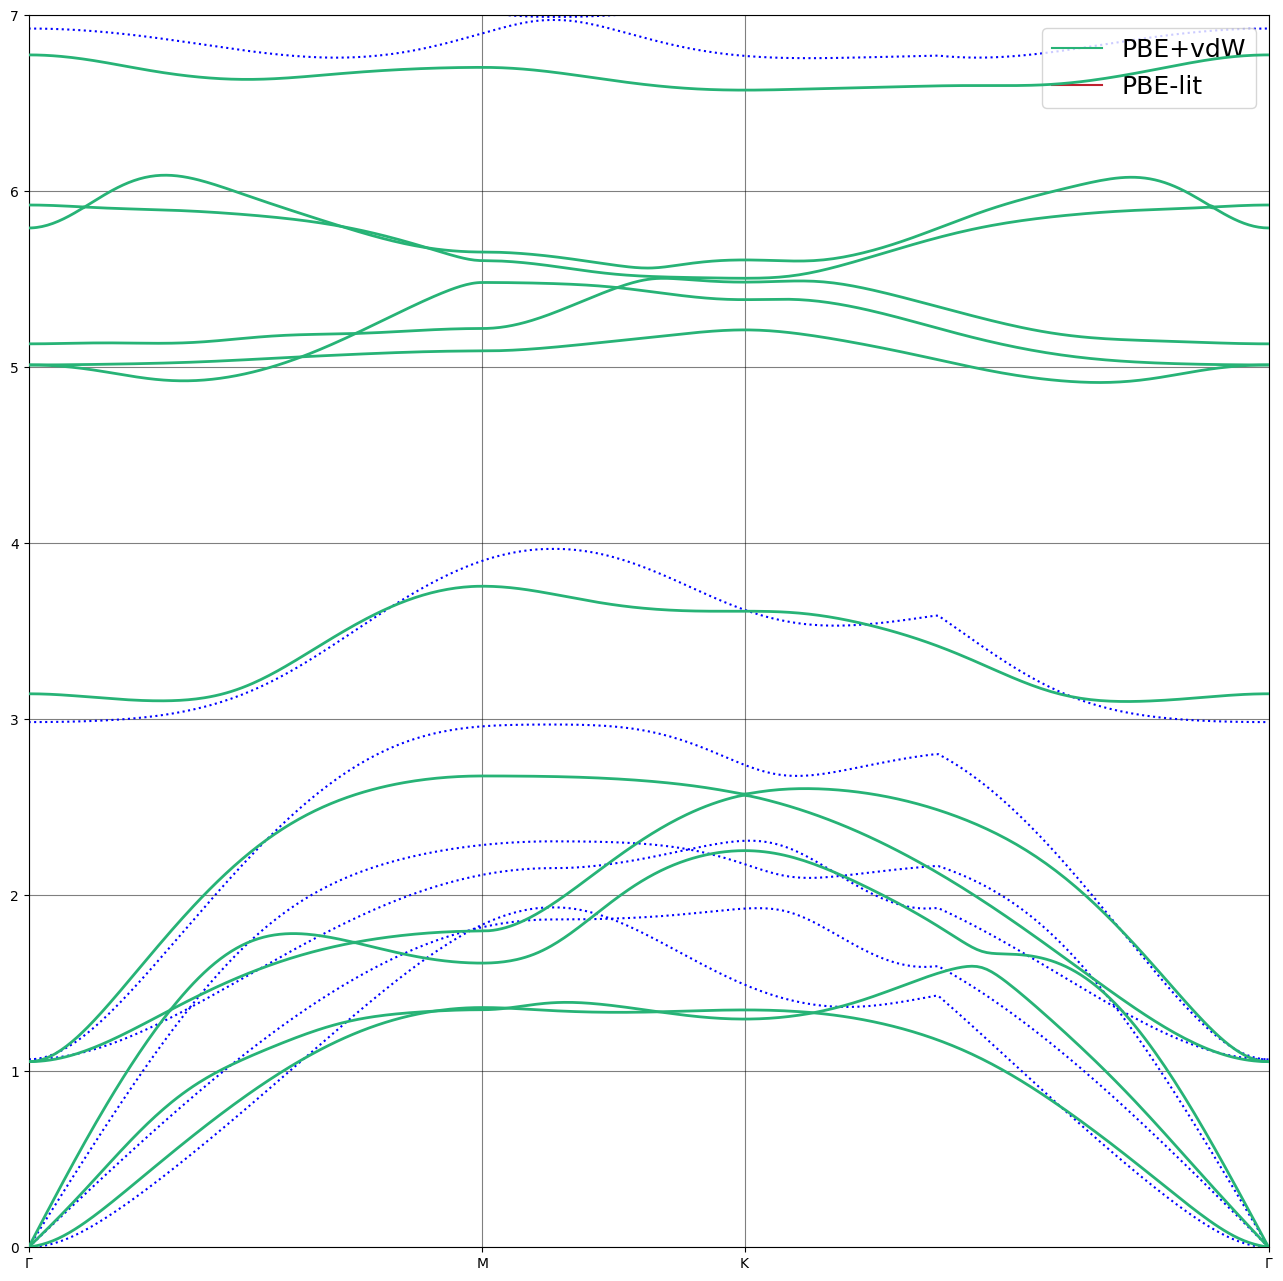

In [17]:
## Plot dispersion relations from QE FREQ.gp files
## Since numpy, and matplotlib is already loaded, we can get started
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot()

# plot literature data
# literature_data = pd.read_csv('../inse/plotdata/literaturedata/monolayer_phonons.csv', header=None, skiprows=2).to_numpy()
# color = '#bf212f'
# for i in range(literature_data.shape[1]//2):
#     x = literature_data[1:,i*2]
#     y = literature_data[1:,(i*2)+1]
    
    
#     # check for nan values
#     args = ~np.isnan(y)
#     x, y =  x[args], y[args]/thz_to_invcm
    
#     # sort by x-values
#     args = np.argsort(x)
#     x, y = x[args], y[args]
    
#     # scale x
#     x0, xf = x.min(), x.max()
#     diff = xf-x0
#     x -= x0
#     x /= x.max()
    
#     # plot
#     y=np.flip(y)
#     ax.plot(x,y, color=color, lw=2)
#     #ax.scatter(x,y, color=color)
    
# first column is x-position, the rest is 3*N degrees of freedom expressed at different k-point
monolayer_data = np.loadtxt('../inse/monolayer/dynamics/FREQ.gp')
xmax = monolayer_data[:, 0].max()
color = '#27b376' # minty green
ax.plot(monolayer_data[:, 0]/xmax, monolayer_data[:, 1:]/thz_to_invcm, color=color, lw=2, zorder=100)

# classical
#monolayer_cls = np.flip(np.loadtxt('../inse/newmdin/MD_input/monolayer/kaldo.out.freq.gp')[:,1:], axis=0)
monolayer_cls = np.loadtxt('../inse/newmdin/MD_input/monolayer/kaldo.out.freq.gp')[:,1:]
for i in range(12):
    si = monolayer_cls.shape[0]
    ax.plot(np.linspace(0,1,si), monolayer_cls[:, i]/thz_to_invcm, color='b', linestyle=':')

sympoints = np.array([0, 169, 292, 398])
sympoints = np.array([monolayer_data[p, 0]/xmax for p in sympoints])
symlabels = [r'$\Gamma$', 'M', 'K', r'$\Gamma$']
labels=['PBE+vdW', 'PBE-lit']
lines=[Line2D([],[],color='#27b376'),
      Line2D([],[],color='#bf212f')]

ax.legend(lines, labels, loc='upper right', fontsize=18)
ax.grid('x', color='k', alpha=0.5, zorder=0)
ax.set_xticks(sympoints, symlabels)
ax.set_ylim([0, 7])
ax.set_xlim([0, 1])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.azim = 36
ax.dist = 7
ax.elev = 5

atoms = read('inse/monolayer/supercell_kpt_forces/rattled_structures_0.extxyz')
forces_gamma = atoms.get_forces()
forces_2kpts = read('inse/monolayer/supercell_kpt_forces/rattled_structures_0-2x2kpt.out', format='espresso-out').get_forces()
diffs = forces_gamma - forces_2kpts
positions = atoms.positions

x, y, z = positions[:,0], positions[:,1], positions[:,2]
u, v, w = forces_gamma[:,0], forces_gamma[:,1], forces_gamma[:,2]
ax.quiver(x, y, z, u, v, w, length=1, normalize=False, color='b', alpha=0.25)

u, v, w = forces_2kpts[:,0], forces_2kpts[:,1], forces_2kpts[:,2]
ax.quiver(x, y, z, u, v, w, length=1, normalize=False, color='r', alpha=0.25)

# Visualize difference vector
# positions_prime = positions+forces_gamma
# x, y, z = positions_prime[:,0], positions_prime[:,1], positions_prime[:,2]
# u, v, w = diffs[:, 0], diffs[:, 1], diffs[:, 2]
# ax.quiver(x, y, z, u, v, w, length=1, normalize=False, color='r')

fig.savefig('inse/plotdata/monolayer/force_compare.png')

In [ ]:
def force_analysis(forces):
    dirs = {0:'x', 1:'y', 2:'z'}
    maxx = forces.max()
    argmax = np.argmax(forces)
    dirmax = dirs[argmax%3]
    
    norms = np.linalg.norm(forces, axis=1)
    meannorm = np.round(norms.mean()*1000,2)
    stdnorm = np.round(norms.std()*1000, 2)
    print('Max Component: {} eV on atom {} in dir {}'.format(maxx, argmax//3, dirmax))
    print(r'Mean norm: {} +/- {} eV'.format(meannorm, stdnorm))

In [ ]:

for i in range(forces_gamma.shape[0]):
        x = forces_gamma[i,:]
        y = forces_2kpts[i,:]
        dotp = np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))
        #print(dotp)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

atoms = read('inse/monolayer/supercell_kpt_forces/rattled_structures_0.extxyz')
forces_gamma = atoms.get_forces()
forces_2kpts = read('inse/monolayer/supercell_kpt_forces/rattled_structures_0-2x2kpt.out', format='espresso-out').get_forces()

x = np.arange(forces_gamma.size)
y1 = np.abs(forces_gamma.flatten())
y2 = np.abs(forces_2kpts.flatten())

ax.scatter(x, y1, color='r', s=15, alpha=1)
ax.scatter(x, y2, color='b', s=65, alpha=0.2)


# Compare QE + Kaldo dispersions

NameError: name 'lines' is not defined

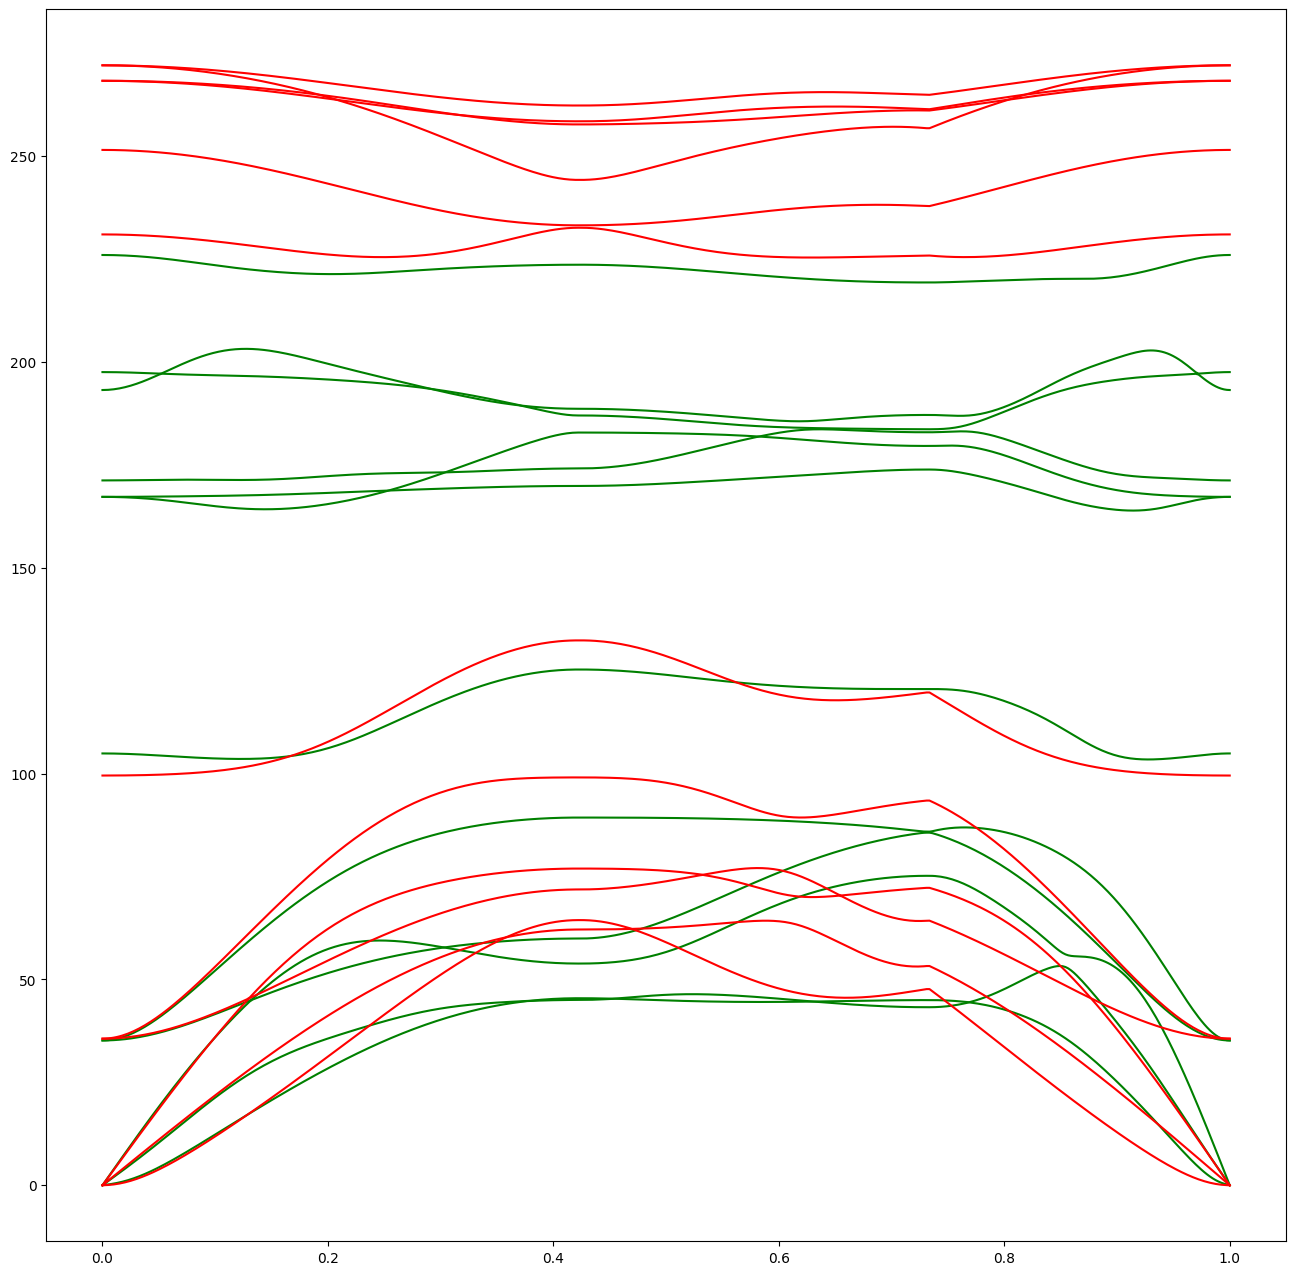

In [17]:
## Plot dispersion relations from QE FREQ.gp files
## Since numpy, and matplotlib is already loaded, we can get started
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot()


# Plot QE generated dispersion
monolayer_dft = np.loadtxt('../inse/monolayer/dynamics/FREQ.gp')
#bilayer_dft = np.loadtxt('../inse/bilayer/dynamics/FREQ.gp')
#bulk_dft = np.loadtxt('../inse/bulk/dynamics/FREQ.gp')

bilayer_cls = np.loadtxt('../inse/newmdin/MD_input/bilayer/kaldo.out.freq.gp')[:, 1:]


color = '#27b376' # minty green
for i in range(12):
    si = monolayer_dft.shape[0]
    ax.plot(np.linspace(0,1,si), monolayer_dft[:, i+1], color='g')



# Plot labeling 
#sympoints = np.array([0, 169, 292, 398])
#sympoints = np.array([monolayer_data[p, 0]/xmax for p in sympoints])
#symlabels = [r'$\Gamma$', 'M', 'K', r'$\Gamma$']
#labels=['PBE+vdW', 'PBE-lit']
#lines=[Line2D([],[],color='#27b376'),
#      Line2D([],[],color='#bf212f')]
ax.legend(lines, labels, loc='upper right', fontsize=18)
ax.grid('x', color='k', alpha=0.5, zorder=0)
ax.set_xticks(sympoints, symlabels)
ax.set_ylim([0, 7])
ax.set_xlim([0, 1])
ax.set_xticks[s]

In [3]:
# This is a reformulation of kaldo's workflow that bypasses the need to 
# format information in the shengbte way in order to use QE data
# Specify unit cell
unitatoms = read('inse/monolayer/scf.in', format='espresso-in')
n_unit = len(unitatoms)

# use kaldo's interfaces.shengbte to use read_second_order_qe_matrix
# then post-process with logic typically used when initiaiting a Second
# Order object in observables.secondorder (lines 132-134)
sc = (9,9,1)
sc_atoms = unitatoms.repeat(sc)
n_replicas = np.prod(sc)
qe_second, qe_supercell = read_second_order_qe_matrix('inse/monolayer/FC')
qe_second = qe_second.reshape((n_unit, 3, n_replicas, n_unit, 3), order='F')
qe_second = qe_second.transpose(3, 4, 2, 0, 1)
qe_grid = 'F'


# Slap this into a second order object with the "from_supercell"
# function which returns the object we'll pass to a Force Constants object
# Note the qe_second is passed in with a new axis added
print('initiating secondorder')
second = SecondOrder.from_supercell(atoms=unitatoms,
                                    grid_type=qe_grid,
                                    supercell=qe_supercell,
                                    value=qe_second[np.newaxis, ...],
                                    is_acoustic_sum=True,
                                    folder='qe+kaldo')


initiating secondorder
2023-06-20 13:33:55,022 - kaldo - INFO - error sum rule: -2.5717145252000693


In [4]:
fcs = ForceConstants(atoms=unitatoms,
                     supercell=sc,
                     folder='qe+kaldo',)
fcs.second = second
phonons = Phonons(forceconstants=fcs,
                  is_classic=False,
                  kpts=(29, 29, 1),
                  is_unfolding=True,
                  temperature=300,
                  folder='qe+kaldo',
                  format='numpy')
phonons.frequency
freq = phonons.frequency
print('min', freq.min(), 'neg:', np.sum(freq<0))

2023-06-20 13:33:58,015 - kaldo - INFO - Using unfolding.
2023-06-20 13:33:58,017 - kaldo - INFO - qe+kaldo/29_29_1/frequency not found in formatted format, calculating frequency
[-9 -9 -1]


2023-06-20 13:33:58.019932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/oneapi/mkl/2023.1.0/lib/intel64:/opt/intel/oneapi/compiler/2023.1.0/linux/lib:/opt/intel/oneapi/compiler/2023.1.0/linux/lib/x64:/opt/intel/oneapi/compiler/2023.1.0/linux/compiler/lib/intel64_lin:/usr/include/mkl/
2023-06-20 13:33:58.019959: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-20 13:33:58.019978: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nicholas-hp): /proc/driver/nvidia/version does not exist
2023-06-20 13:33:58.020268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perf

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()